In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
zip_path = "/content/drive/MyDrive/archive.zip"

In [3]:
!unzip -q "/content/drive/MyDrive/archive.zip" #unzips without printing so this doesn't print a billion things

In [4]:
import os, shutil, random

SRC = "/content/ai_art_classification/train"
DST = "/content/sample_train"
os.makedirs(DST, exist_ok=True)

classes = ["AI_GENERATED", "NON_AI_GENERATED"]
images_per_class = 1000 #2 classes so 2000 images

for cls in classes:
    src_class_dir = os.path.join(SRC, cls)
    if not os.path.isdir(src_class_dir):
        raise FileNotFoundError(f"Expected class dir not found: {src_class_dir}")
    dst_class_dir = os.path.join(DST, cls)
    os.makedirs(dst_class_dir, exist_ok=True)

    files = [f for f in os.listdir(src_class_dir) if f.lower().endswith(('jpg','jpeg','png'))]
    pick = random.sample(files, min(images_per_class, len(files)))

    #this is to copy every selected image into the new dataset
    for f in pick:
        src_fp = os.path.join(src_class_dir, f)
        dst_fp = os.path.join(dst_class_dir, f)
        try:
            # creating symlink for performance reasons
            if not os.path.exists(dst_fp):
                os.symlink(src_fp, dst_fp)
        except Exception:
            # failsafe incase it fails so it'll just copy.
            shutil.copy2(src_fp, dst_fp)

print("sample dataset here:", DST)

sample dataset here: /content/sample_train


In [5]:
import os, shutil, random

SOURCE = "/content/sample_train"
DEST = "/content/split_dataset"

train_ratio = 0.8

classes = ["AI_GENERATED", "NON_AI_GENERATED"] #two classes we wanna split

# create new structure
for split in ["train", "val"]:
    for cls in classes:
        os.makedirs(os.path.join(DEST, split, cls), exist_ok=True)

for cls in classes:
    src = os.path.join(SOURCE, cls)
    files = [f for f in os.listdir(src) if f.lower().endswith(('jpg','jpeg','png'))] #getting all images
    random.shuffle(files) #ensuring randomness
    #splitting index based on ratio and then partitioning the images
    split_idx = int(len(files) * train_ratio)
    train_files = files[:split_idx]
    val_files   = files[split_idx:]

    # copying each file into the training folder, and then validation folder.
    for f in train_files:
        shutil.copy(os.path.join(src, f),
                    os.path.join(DEST, "train", cls, f))
    for f in val_files:
        shutil.copy(os.path.join(src, f),
                    os.path.join(DEST, "val", cls, f))

print("Train/Validation split created at:", DEST)


✨ Train/Validation split created at: /content/split_dataset


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DATA_DIR = "/content/split_dataset"
IMG_SIZE = (224, 224)   # downsizing image res
BATCH_SIZE = 32

# training data generator with augmentation, for new varied versions of images.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
)
# generator to load images
train_gen = train_datagen.flow_from_directory(
    directory=os.path.join(DATA_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

# validation generator but with no augmentation
val_datagen = ImageDataGenerator(rescale=1./255)
#loading the images in
val_gen = val_datagen.flow_from_directory(
    directory=os.path.join(DATA_DIR, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

print("good to go")


Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
good to go


In [7]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

IMG_SIZE = (224, 224)

#using efficientnetB0
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

#freezing base layers
base_model.trainable = False

#classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [8]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 74s 907ms/step - accuracy: 0.5264 - loss: 0.7072 - val_accuracy: 0.5000 - val_loss: 0.6987
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 471ms/step - accuracy: 0.5103 - loss: 0.6973 - val_accuracy: 0.5000 - val_loss: 0.6960
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 420ms/step - accuracy: 0.5115 - loss: 0.6982 - val_accuracy: 0.5000 - val_loss: 0.6942
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 448ms/step - accuracy: 0.5123 - loss: 0.7035 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 428ms/step - accuracy: 0.5183 - loss: 0.6956 - val_accuracy: 0.5000 - val_loss: 0.6941
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 434ms/step - accuracy: 0.5270 - loss: 0.6917 - val_accuracy: 0.5000 - val_loss: 0.6941
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 449ms/step - accuracy: 0.5107 - loss: 0.6986 - val_accuracy: 0.5075 - val_loss: 0.6907
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 425ms/step - accuracy: 0.5083 - loss: 0.6961 - val_accu

In [9]:
base_model.trainable = True

# Fine-tune only last ~50 layers
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1
)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 67s 705ms/step - accuracy: 0.5222 - loss: 0.6977 - val_accuracy: 0.5225 - val_loss: 0.6892
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 452ms/step - accuracy: 0.5294 - loss: 0.6874 - val_accuracy: 0.5025 - val_loss: 0.6911
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 469ms/step - accuracy: 0.5749 - loss: 0.6817 - val_accuracy: 0.5025 - val_loss: 0.6936
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 460ms/step - accuracy: 0.5351 - loss: 0.6963 - val_accuracy: 0.5650 - val_loss: 0.6885
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 428ms/step - accuracy: 0.5491 - loss: 0.6846 - val_accuracy: 0.5000 - val_loss: 0.6925
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 458ms/step - accuracy: 0.5499 - loss: 0.6842 - val_accuracy: 0.5000 - val_loss: 0.6952
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 448ms/step - accuracy: 0.5523 - loss: 0.6812 - val_accuracy: 0.5000 - val_loss: 0.7054
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 464ms/step - accuracy: 0.5922 - loss: 0.6751 - val_accu

13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 586ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       200
           1       0.00      0.00      0.00       200

    accuracy                           0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.33       400

Confusion matrix:
 [[200   0]
 [200   0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


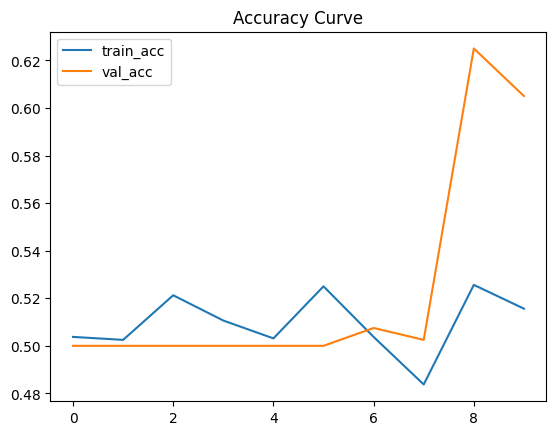

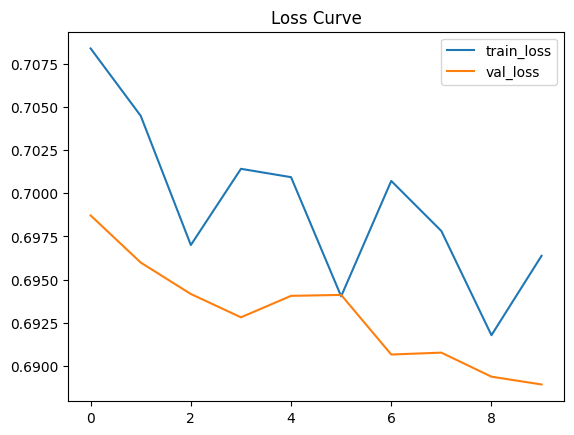

In [10]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

#predict
val_gen.reset()
preds = model.predict(val_gen)
pred_labels = (preds > 0.5).astype(int)

true_labels = val_gen.classes

print("Classification Report:")
print(classification_report(true_labels, pred_labels))

#confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
print("Confusion matrix:\n", cm)

#accuracy curve
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

#loss curve
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss Curve")
plt.show()
